In this notebook I use the trained model to predict bounding boxes on new images.
Those images should be images of a few routes from different angles/distances from different cameras/ different time of days.  
The found bboxes will be used to do a feature matching between those images and images from the database.

The model trained on images of size ~400x800 - need to check if it makes a difference with/without resize.

In [1]:
#check LD_LIBRARY_PATH set
!conda env config vars list

/bin/bash: /home/ella/miniconda3/envs/tf2_gpu_berta/lib/libtinfo.so.6: no version information available (required by /bin/bash)
LD_LIBRARY_PATH = :/home/ella/miniconda3/envs/tf2_gpu_berta/lib:/home/ella/miniconda3/envs/tf2_gpu_berta/lib


In [2]:
import pandas as pd
import numpy as np

from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf

import cv2
from PIL import Image
import os

from skimage import io
import matplotlib.pyplot as plt

from glob import glob

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
imgs_dir = 'imgs'

In [4]:
imgs_path = glob(os.path.join(imgs_dir, '*.JPG'))
imgs_name = [os.path.basename(f) for f in imgs_path]

imgs_path[0], imgs_name[0]

('imgs/IMG_4427.JPG', 'IMG_4427.JPG')

In [5]:
## Load images to predict bbox on:
imgs = [io.imread(im_path) for im_path in imgs_path]
imgs[0].shape

(3264, 2448, 3)

In [6]:
## resize images:
## omg, cv2 flips vertical and horizontal here
resize_size = (imgs[0].shape[1]//4, imgs[0].shape[0]//4)
imgs = [cv2.resize(im, resize_size) for im in imgs]

print(imgs[0].shape)

(816, 612, 3)


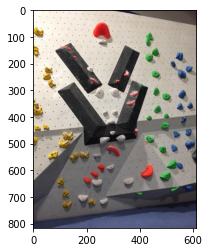

In [7]:
plt.imshow(imgs[0])

In [10]:
resized_path = os.path.join(imgs_dir, 'resized0.25') 
os.makedirs(resized_path, exist_ok=True)
for i,im in enumerate(imgs):
    io.imsave(os.path.join(resized_path, imgs_name[i]), im)

Adjust the DETECTION_THRESHOLD to change the sensitivity of the model.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.


In [26]:
classes = ['label', 'climbing_hold']

def preprocess_image(image_path, input_size):
    """Preprocess the input image to feed to the TFLite model"""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    original_image = img
    resized_img = tf.image.resize(img, input_size)
    resized_img = resized_img[tf.newaxis, :]
    resized_img = tf.cast(resized_img, dtype=tf.uint8)
    return resized_img, original_image


def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""

    signature_fn = interpreter.get_signature_runner()

    # Feed the input image to the model
    output = signature_fn(images=image)

    # Get all outputs from the model
    count = int(np.squeeze(output['output_0']))
    scores = np.squeeze(output['output_1'])
    classes = np.squeeze(output['output_2'])
    boxes = np.squeeze(output['output_3'])

    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
            }
            results.append(result)
    return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
    """Run object detection on the input image and draw the detection results"""
    # Load the input shape required by the model
    _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(
        image_path,(input_height, input_width))

    # Run object detection on the input image
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

    # Plot the detection results on the input image
    original_image_np = original_image.numpy().astype(np.uint8)
    
    ## bounding boxes to csv:
    df = pd.DataFrame(columns=('idx', 'xmin', 'ymin', 'xmax', 'ymax'))
    
    for ii,obj in enumerate(results):
        # Convert the object bounding box from relative coordinates to absolute
        # coordinates based on the original image resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_image_np.shape[1])
        xmax = int(xmax * original_image_np.shape[1])
        ymin = int(ymin * original_image_np.shape[0])
        ymax = int(ymax * original_image_np.shape[0])
        
        df_bbox = pd.DataFrame({'idx':[ii], 'xmin':[xmin], 'ymin':[ymin], 'xmax':[xmax], 'ymax':[ymax]})
        df = pd.concat((df,df_bbox))

        # Find the class index of the current object
        class_id = int(obj['class_id'])

        # Draw the bounding box and label on the image
        #color = [int(c) for c in COLORS[class_id]]
        #print((xmin, ymin), (xmax, ymax))
        cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        # Make adjustments to make the label visible for all objects
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
        cv2.putText(original_image_np, label, (xmin, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Return the final image
    original_uint8 = original_image_np.astype(np.uint8)
    return original_uint8, df

In [27]:
DETECTION_THRESHOLD = 0.2 

output_dir = 'predictions_new_imgs_from_resized'
model_num = 4

model_path = f'model{model_num}.tflite'
os.makedirs(os.path.join(output_dir,f'model{model_num}'), exist_ok=True)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

for file in imgs_name:
    TEMP_FILE = os.path.join(resized_path, file)

    # Run inference and draw detection result on the local copy of the original file
    detection_result_image, df = run_odt_and_draw_results(
        TEMP_FILE,
        interpreter,
        threshold=DETECTION_THRESHOLD
    )

    df.to_csv(os.path.join(output_dir, f'model{model_num}', f'{file}.csv'))
    Image.fromarray(detection_result_image).save(os.path.join(output_dir, f'model{model_num}', file))